<a href="https://colab.research.google.com/github/utkarsh0702/Tensorflow/blob/master/Time_Series_prediction2_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

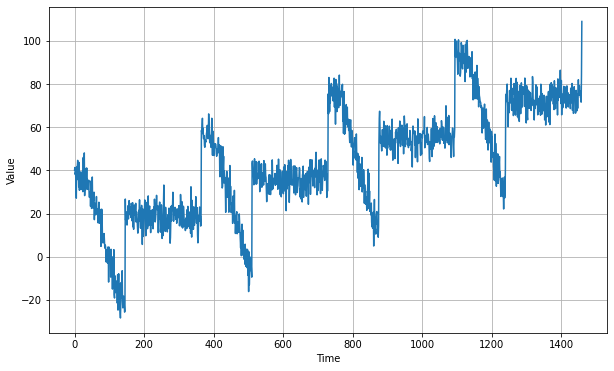

In [0]:
def plot_series(time, series,format='-', start=0, end=None):
	plt.plot(time[start:end], series[start:end], format)
	plt.xlabel('Time')
	plt.ylabel('Value')
	plt.grid(True)

def trend(time, slope=0):
	return time*slope

def seasonal_pattern(season_time):
	return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
	season_time= ((time+phase)%period)/period
	return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
	rnd= np.random.RandomState(seed)
	return rnd.randn(len(time))*noise_level

time= np.arange(4*365+1, dtype='float32')
baseline=0
series= trend(time, 0.1)
amplitude=40
slope=0.05
noise_level=5

series= baseline+trend(time, slope)+seasonality(time, period=365, amplitude= amplitude)
series+=noise(time, noise_level, seed=45)
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
	dataset= tf.data.Dataset.from_tensor_slices(series)
	dataset= dataset.window(window_size+1, shift=1, drop_remainder=True)
	dataset= dataset.flat_map(lambda x: x.batch(window_size+1))
	dataset= dataset.shuffle(shuffle_buffer).map(lambda x:(x[:-1], x[-1]))
	dataset= dataset.batch(batch_size).prefetch(1)
	return dataset

split= 1000
time_train=time[:split]
x_trin=series[:split]
time_valid=time[split:]
x_valid=series[split:]

window_size=20
batch_size=32
shuffle_buffer_size=1000

dataset= windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [0]:
keras.backend.clear_session()
#Callback and updation of learning rate
model= keras.models.Sequential([
                                keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
                                keras.layers.Dense(10, activation='relu'),
                                keras.layers.Dense(1)
])

lr_schedular= keras.callbacks.LearningRateScheduler(lambda x: 1e-8*10**(x/20))

model.compile(loss='mse', optimizer= keras.optimizers.SGD(lr= 1e-8, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [0]:
history= model.fit(dataset, epochs= 100, callbacks= [lr_schedular])

Epoch 1/100
46/46 [==============================] - 0s 3ms/step - loss: 1873.9672 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 1367.7454 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 965.0861 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 624.7023 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 385.4953 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 241.9109 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 158.1740 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 117.5696 - lr: 2.2387e-08
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 110.3809 - lr: 2.5119e-08
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 106.2811 - lr: 2.8184e-08
Epoch 1

In [0]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)

2.818383e-05


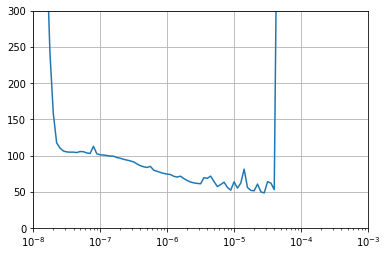

In [0]:
lrs= 1e-8*(10**(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3,0,300])
plt.grid(True)


In [0]:
keras.backend.clear_session()

model= keras.models.Sequential([
                                keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
                                keras.layers.Dense(10, activation='relu'),
                                keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer= keras.optimizers.SGD(lr= lr, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [0]:
class Call_back(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss')<0.4 :
      print('\n Cancelling the training.........')
      self.model.stop_training= True

Call= Call_back()
history= model.fit(dataset, epochs= 200, verbose=1, callbacks=[Call])

Epoch 1/200
46/46 [==============================] - 0s 3ms/step - loss: 242.5923
Epoch 2/200
46/46 [==============================] - 0s 3ms/step - loss: 72.2715
Epoch 3/200
46/46 [==============================] - 0s 4ms/step - loss: 75.6319
Epoch 4/200
46/46 [==============================] - 0s 3ms/step - loss: 127.4241
Epoch 5/200
46/46 [==============================] - 0s 4ms/step - loss: 105.2871
Epoch 6/200
46/46 [==============================] - 0s 3ms/step - loss: 92.5638
Epoch 7/200
46/46 [==============================] - 0s 3ms/step - loss: 62.3707
Epoch 8/200
46/46 [==============================] - 0s 3ms/step - loss: 77.6737
Epoch 9/200
46/46 [==============================] - 0s 3ms/step - loss: 49.7329
Epoch 10/200
46/46 [==============================] - 0s 3ms/step - loss: 57.4869
Epoch 11/200
46/46 [==============================] - 0s 3ms/step - loss: 53.9964
Epoch 12/200
46/46 [==============================] - 0s 3ms/step - loss: 66.8632
Epoch 13/200
46/46 [==

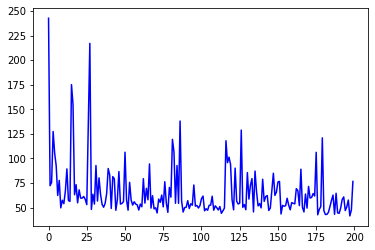

In [0]:
loss= history.history['loss']
epochs= range(len(loss))
plt.plot(epochs, loss,'b', label='Training Loss')
plt.show()

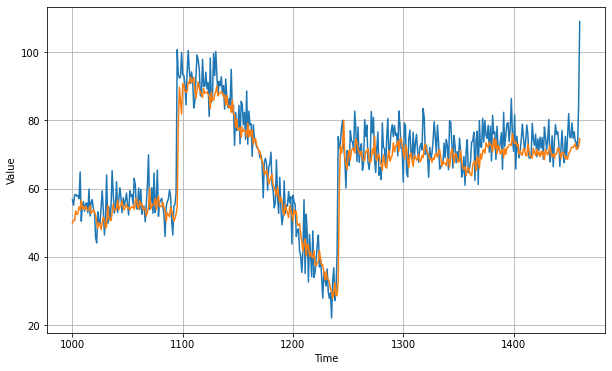

In [0]:
#Forecast prediction
forecast=[]
for time in range(len(series)- window_size):
	forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast= forecast[split- window_size:]
results= np.array(forecast)[:,0,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
#metrics
keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.962009